<a href="https://colab.research.google.com/github/JaafarBK02/CS122/blob/main/social_media_analysis_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib wordcloud textblob pytest


In [ ]:
import pandas as pd
import seaborn as sbs
df = pd.read_csv('social_media_posts.csv')
df.head()


,user_id,post_id,post_content,likes,shares,post_date
0,1001,1,Loving the new iPhone! #Apple #Tech https://ap...,120.0,50.0,2024-02-20
1,1002,2,NaN,95.0,30.0,2024-02-19
2,1003,3,Check out my new sneakers! #Nike #style 👟,NaN,75.0,2024-02-18
3,1004,4,Can’t wait to travel again! ✈️ #wanderlust #tr...,180.0,65.0,2024-02-17
4,1005,5,What a disaster... didn’t work at all! 😞 #fail,50.0,20.0,2024-02-16


### Data Wrangling/Munging

In [ ]:
# Let's start by handling missing values.
print("----- Missing values count -----")
print(df.isnull().sum())

#likes
median_likes= df['likes'].median()
df['likes'] = df['likes'].fillna(median_likes)
print(f"\nFilled 'likes' with median value: {median_likes}")

#shares
mean_shares=df['shares'].mean()
df['shares'] = df['shares'].fillna(mean_shares)
print(f"Filled 'shares' with mean value: {round(mean_shares)}")

#post_content
df['post_content']= df['post_content'].fillna('No Text')
print("Filled 'post_content' with 'No Text'")


----- Missing values count -----
user_id         0
post_id         0
post_content    0
likes           0
shares          0
post_date       0
dtype: int64

Filled 'likes' with median value: 210.0
Filled 'shares' with mean value: 87
Filled 'post_content' with 'No Text'


In [ ]:
# Let's clean post_content
import re

#helpers
URL_RE = re.compile(r'https?://\S+|www\.\S+')
TAG_RE = re.compile(r'[#@][A-Za-z0-9_]+')
EMO_RE = re.compile(r'[\U00010000-\U0010ffff]')
PUNC_RE = re.compile(r'[^\w\s]')



# functions
def clean_post_content(text):
 """: Cleans the text by removing URLs, mentions, hashtags,punctuation, emojis, and extra spaces. Returns a plain string containing only the cleaned text."""
 text = str(text)
 text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove URLs
 text = re.sub(r'[@#][A-Za-z0-9_]+', '', text)  # remove # and @
 text = re.sub(r'[\U00010000-\U0010ffff]', '', text) # remove emojis
 text = re.sub(r'[^\w\s]', '', text)  # remove punctuation

 return text


df['clean_post_content'] = df['post_content'].apply(clean_post_content)

In [ ]:
# Lastly, we will Convert post_date to datetime format and extract hashtags and store them in a new column Hashtags

df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce')


def extract_hashtags(text: str) -> list[str]:
    return re.findall(r'#\w+', str(text))

def extract_mentions(text: str) -> list[str]:
    return re.findall(r'@\w+', str(text))

df['Hashtags'] = df['post_content'].apply(extract_hashtags)


In [ ]:
#Identify the Top 3 users by total engagement (average likes + average shares).
def get_avg_engagement(df):
  user_engagement= df.groupby('user_id')[['likes','shares']].mean().reset_index()
  user_engagement['total_engagment'] = user_engagement['likes']+ user_engagement['shares']
  top3_users= user_engagement.sort_values('total_engagment', ascending=False).head(3)
  return top3_users
  get_avg_engagement(df)

In [ ]:
#Determine the Top 5 hashtags based on frequency of appearance.
hashtags_serie= df['Hashtags'].explode()
hashtags_serie= hashtags_serie.dropna()
top5_hashttags= hashtags_serie.value_counts().head(5)

print("Top 5 hashtags by frequency of appearance: ")
print(f"\n")
print(top5_hashttags)

Top 5 hashtags by frequency of appearance: 


Hashtags
#outdoorfun    27
#foodie        26
#cozytime      20
#adventure     20
#goodtimes     20
Name: count, dtype: int64


In [ ]:
from textblob import TextBlob


def get_sentiment(text: str) -> float:
    return float(TextBlob(str(text)).sentiment.polarity)

df['polarity']= df['post_content'].apply(get_sentiment)

def label_sentiment(p):
  if p>0: return 'positive'
  elif p<0: return 'negative'
  else: return 'neutral'

df['sentiment']= df['polarity'].apply(label_sentiment)

print(' overall sentiment distribution:', df['sentiment'].value_counts())

avg_sentiment= df.groupby('user_id')['polarity'].mean()
print(f'\n')
print(avg_sentiment)


 overall sentiment distribution: sentiment
positive    334
neutral      97
negative     69
Name: count, dtype: int64


user_id
1001    0.369253
1002    0.231697
1003    0.294621
1004    0.427089
1005    0.307570
          ...   
1116    0.000000
1117    1.000000
1118   -0.100000
1119    0.000000
1120    0.300000
Name: polarity, Length: 120, dtype: float64


###Visualization

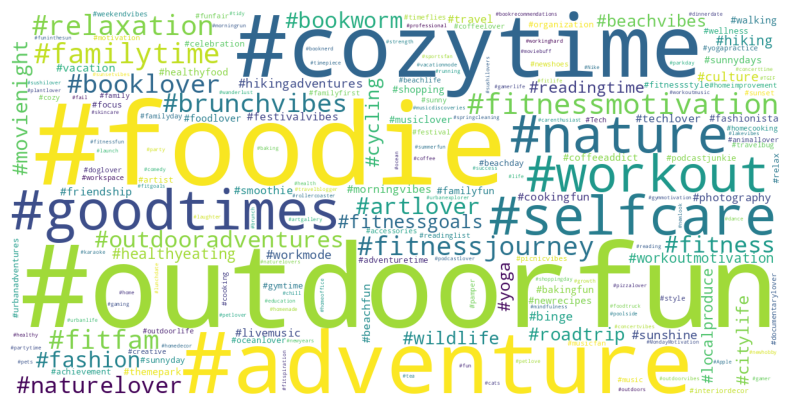

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

freqs = hashtags_serie.value_counts().to_dict()
wc = WordCloud(width=1200, height=600, background_color='white')
wc = wc.generate_from_frequencies(freqs)
plt.figure(figsize=(10, 5))
plt.imshow(wc)
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()


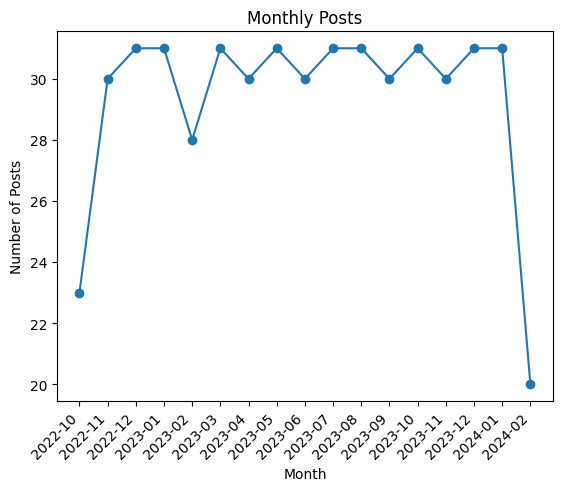

In [ ]:
# Monthly Posts (line plot)
monthly_posts = df['post_date'].dt.to_period('M').value_counts().sort_index()

plt.plot(monthly_posts.index.astype(str), monthly_posts.values, marker='o')
plt.title('Monthly Posts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.savefig('monthly_posts.png')

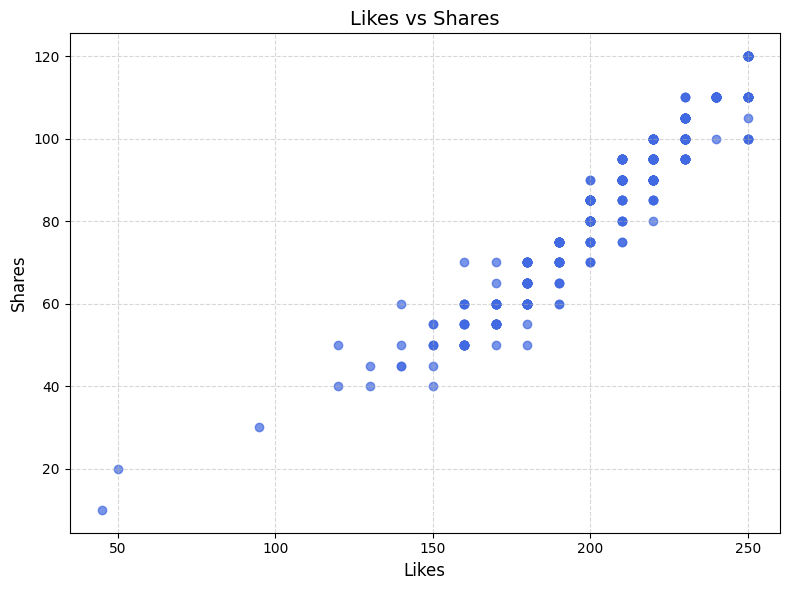

In [ ]:
#Likes vs Shares (scatter plot)
plt.figure(figsize=(8,6))
plt.scatter(df['likes'], df['shares'], color='royalblue', alpha=0.7)
plt.title('Likes vs Shares', fontsize=14)
plt.xlabel('Likes', fontsize=12)
plt.ylabel('Shares', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('likes_vs_shares.png')
plt.show()

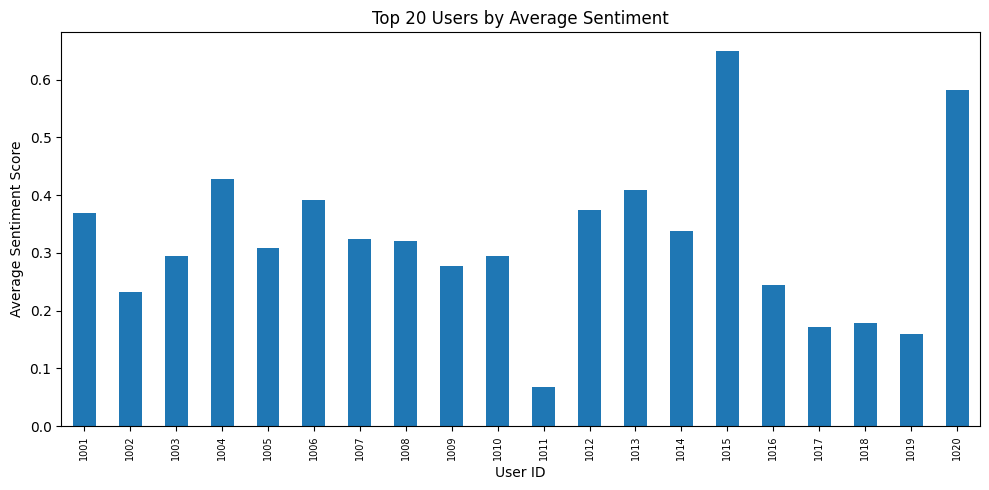

In [ ]:
plt.figure(figsize=(12,5))
#plt.bar(avg_sentiment.index.astype(str), avg_sentiment.values, color='skyblue')
avg_sentiment.head(20).plot(kind='bar', figsize=(10,5)) # to make it readable
#plt.title('Average Sentiment per User')
plt.title('Top 20 Users by Average Sentiment')
plt.xlabel('User ID')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('avg_sentiment_per_user.png', dpi=200)
plt.show()

In [ ]:
!pytest -v test_homework.py
# If your test uses unittest instead, run:
# !python -m unittest -v test_homework.py


============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: typeguard-4.4.4, anyio-4.11.0, langsmith-0.4.37
collected 3 items                                                              

test_homework.py::TestSocialMediaAnalysis::test_avg_engagement PASSED    [ 33%]
test_homework.py::TestSocialMediaAnalysis::test_clean_post_content PASSED [ 66%]
test_homework.py::TestSocialMediaAnalysis::test_sentiment_analysis PASSED [100%]

============================== 3 passed in 1.60s ===============================
